In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Import necessary packages.
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.checkpoint as C
import torchvision.transforms.functional as fn
import torchvision.transforms as T
from tqdm.notebook import tqdm

# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset

!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp

!pip install -q torchsummary
from torchvision import models
from torchsummary import summary

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

# Config

In [5]:
class CFG:
    
    # Path to the data folder (Thanks to @Kenni)
    GLOBAL_PATH = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
    
    # base image size
    resize_value = 256
    
    # resize image
    resize = False
    if resize:
        resize_value = 384
        
    # Model Settings    
    model = 'UNET'
    encoder = 'efficientnet-b0'
    weights = 'imagenet'
    
    batch_size = 16
    optimizer='Adam'
    lr = 5e-4
    epochs = 20

# Custom dataset

In [7]:
#A custom Dataset class must implement three functions: __init__, __len__, and __getitem__
class ContrailDataset(Dataset):
    
    def __init__(self, base_dir, data_type='train'):
        assert data_type in ['train', 'validation'], \
            "'data_type' should be one of 'train_images' or 'validate_images'"
        
        self.base_dir = base_dir
        self.data_type = data_type
        self.record = os.listdir(self.base_dir +'/'+ self.data_type)
       
        self.resize_image = T.Resize(CFG.resize_value,interpolation=T.InterpolationMode.BILINEAR,antialias=True)
        self.resize_mask = T.Resize(CFG.resize_value,interpolation=T.InterpolationMode.NEAREST,antialias=True)
   
    def __len__(self):
        return len(self.record)

    def __getitem__(self, idx):
        
        record_id = self.record[idx]
        record_dir = os.path.join(self.base_dir, self.data_type, record_id)
        
        #--------------------------Combine bands into a false color image---------------------------------------
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        N_TIMES_BEFORE = 4

        def normalize_range(data, bounds):
            """Maps data to the range [0, 1]."""
            return (data - bounds[0]) / (bounds[1] - bounds[0])
        
        with open(os.path.join(record_dir, 'band_11.npy'), 'rb') as f:
            band11 = np.load(f)
        with open(os.path.join(record_dir, 'band_14.npy'), 'rb') as f:
            band14 = np.load(f)
        with open(os.path.join(record_dir, 'band_15.npy'), 'rb') as f:
            band15 = np.load(f)

        r = np.clip(normalize_range(band15 - band14, _TDIFF_BOUNDS), 0, 1)
        g = np.clip(normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS), 0, 1)
        b = np.clip(normalize_range(band14, _T11_BOUNDS), 0, 1)

        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)        #(256, 256, 3, 8)
        false_color = torch.from_numpy(false_color)#.clone().detach()   #torch.Size([256, 256, 3, 8]) 
        false_color = torch.moveaxis(false_color, -2, 0)                #torch.Size([3, 256, 256, 8])
        false_color = false_color[..., N_TIMES_BEFORE]                  #torch.Size([3, 256, 256])
        #-------------------------------------------------------------------------------------------------------
        
        human_pixel_mask = np.load(os.path.join(record_dir, 'human_pixel_masks.npy'))  #(256, 256, 1)
        human_pixel_mask = torch.from_numpy(human_pixel_mask)#.clone().detach()        #torch.Size([256, 256, 1])
        human_pixel_mask = torch.moveaxis(human_pixel_mask, -1, 0)                     #torch.Size([1, 256, 256])
        
            
        if self.data_type == 'train':
            # data augmentation
            random_crop_factor = torch.rand(1)
            crop_min, crop_max = 0.5 , 1
            crop_factor = crop_min + random_crop_factor * (crop_max-crop_min) 
            crop_size = int(crop_factor * 256)
            self.crop = T.CenterCrop(size=crop_size)
            
            false_color = self.crop(false_color)
            human_pixel_mask =  self.crop(human_pixel_mask)
            
            false_color = self.resize_image(false_color)
            human_pixel_mask =  self.resize_mask(human_pixel_mask)
        
        if CFG.resize and self.data_type=='validation':
            false_color = self.resize_image(false_color)
            human_pixel_mask =  self.resize_mask(human_pixel_mask)
                  
        # false color is scaled between 0 and 1!
        return false_color, human_pixel_mask.float()

# Dataloader

In [8]:
training_data = ContrailDataset(base_dir=CFG.GLOBAL_PATH, data_type='train')
train_dataloader = DataLoader(
    training_data, 
    batch_size = CFG.batch_size, 
    shuffle = True, 
    num_workers = 2 if torch.cuda.is_available() else 0,
    pin_memory = True,
    drop_last = True
)

validation_data = ContrailDataset(base_dir=CFG.GLOBAL_PATH, data_type='validation')
validation_dataloader = DataLoader(
    validation_data, 
    batch_size = CFG.batch_size, 
    shuffle = False, 
    num_workers = 2 if torch.cuda.is_available() else 0,
    pin_memory = True,
    drop_last = True
)

# Show some Images from the Dataloaders

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
torch.Size([16, 256, 256, 3]) torch.Size([16, 256, 256, 1])


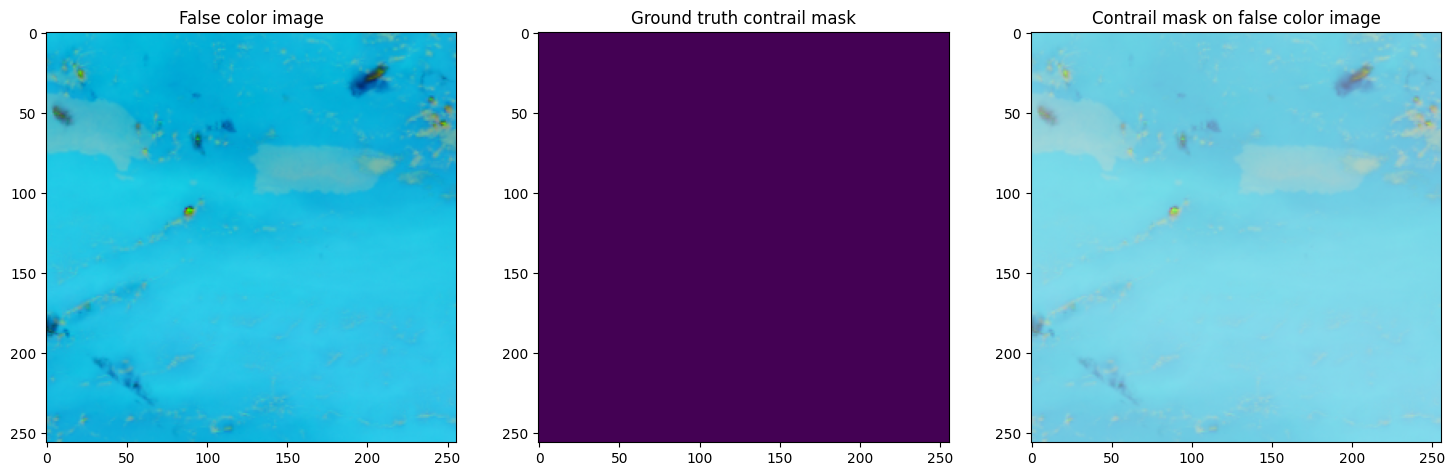

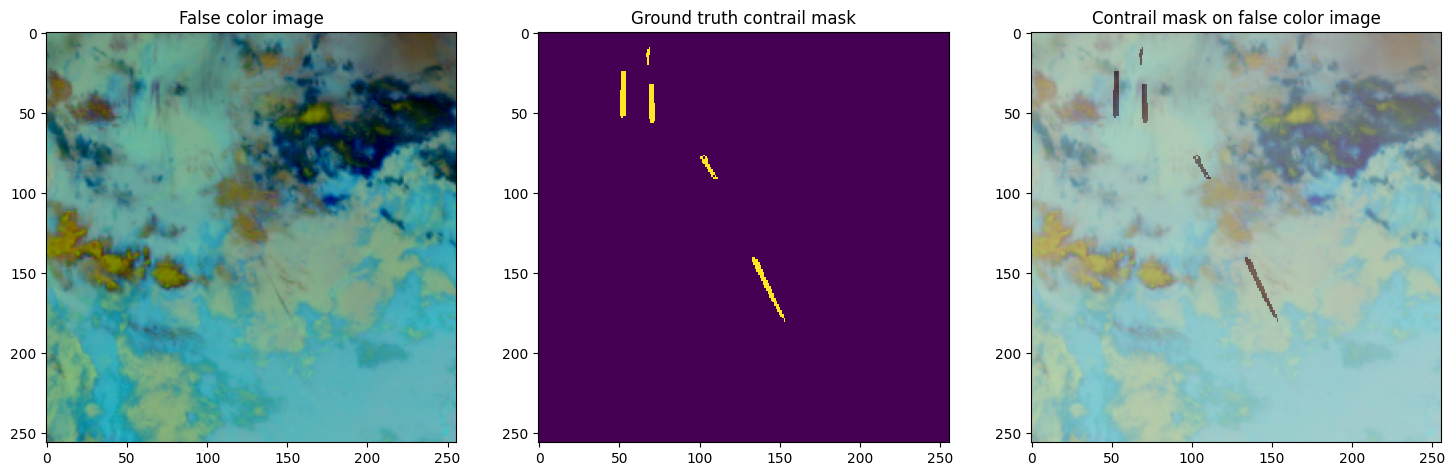

In [9]:
image, mask = next(iter(validation_dataloader))
print(image.shape, mask.shape)

image = torch.moveaxis(image, 1, -1)
mask = torch.moveaxis(mask, 1, -1)
print(image.shape, mask.shape)

for i in range(2):

    plt.figure(figsize=(18, 6))
    
    ax = plt.subplot(1, 3, 1)
    ax.imshow(image[i])
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(mask[i], interpolation='none')
    ax.set_title('Ground truth contrail mask')
        
    ax = plt.subplot(1, 3, 3)
    ax.imshow(image[i])
    ax.imshow(mask[i], cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image');

# Create the Model (from SMP)

In [10]:
if CFG.model == 'UNET':
    model = smp.Unet(
    encoder_name =CFG.encoder,
    encoder_weights=CFG.weights,    # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,        # model output channels (number of classes in your dataset)
    activation="sigmoid",
    )
    model.to(device)
    summary(model, (3, 256, 256))


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 136MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 257, 257]               0
Conv2dStaticSamePadding-2         [-1, 32, 128, 128]             864
       BatchNorm2d-3         [-1, 32, 128, 128]              64
MemoryEfficientSwish-4         [-1, 32, 128, 128]               0
         ZeroPad2d-5         [-1, 32, 130, 130]               0
Conv2dStaticSamePadding-6         [-1, 32, 128, 128]             288
       BatchNorm2d-7         [-1, 32, 128, 128]              64
MemoryEfficientSwish-8         [-1, 32, 128, 128]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

# Optimizer

In [13]:
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=2)
print(f'learning rate: {optimizer.param_groups[0]["lr"]}')

learning rate: 0.0005


# Loss function

In [14]:
def dice_global(y_p, y_t, smooth=1e-3):
    intersection = torch.sum(y_p * y_t)
    union = torch.sum(y_p) + torch.sum(y_t)

    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice

def dice_loss_global(y_p, y_t):
    return 1 - dice_global(y_p, y_t)

# Average dice score for the examples in a batch
def dice_avg(y_p, y_t, smooth=1e-3):
    i = torch.sum(y_p * y_t, dim=(2, 3))
    u = torch.sum(y_p, dim=(2, 3)) + torch.sum(y_t, dim=(2, 3))
    score = (2 * i + smooth)/(u + smooth)
    return torch.mean(score)

def dice_loss_avg(y_p, y_t):
    return 1-dice_score_jan(y_p, y_t)

# Training

In [ ]:
train_dice_global, train_dice_avg = [], []
eval_dice_global, eval_dice_avg = [], []
bst_dice = 0
bst_epoch = 1
for epoch in range(1, CFG.epochs+1):
    
    print(f'________epoch: {epoch}________')
    
    # Early stopping
    if epoch-bst_epoch >=5:
        print(f'early stopping in epoch {epoch}')
        break
    
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()
    
    # record information in training
    tot_loss_global, tot_dice_global, tot_dice_avg = 0, 0, 0
    
    bar = tqdm(train_dataloader)
    count = 0
    for image, mask in bar:
        
        image = torch.nn.functional.interpolate(image, 
                                                size=CFG.resize_value,
                                                mode='bilinear'
                                               )
        
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(image.to(device))
        mask = mask.to(device)
        
        # If the image was resized, use a resizing step to make 256 again
        if CFG.resize:
            logits = torch.nn.functional.interpolate(logits, 
                                                     size=256,
                                                     mode='bilinear'
                                                    )
            
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        
        # Calculate the dice loss 
        loss = dice_loss_global(logits, mask)
        
        # Compute the gradients for parameters.
        loss.backward()
        
        # Update the parameters with computed gradients.
        optimizer.step()

        tot_loss_global += loss.item()
        tot_dice_global += 1 - loss.item()
        tot_dice_avg += dice_avg(logits, mask).item()
        count += 1
        bar.set_postfix(TrainDiceLossGlobal=f'{tot_loss_global/count:.4f}', 
                        TrainDiceGlobal=f'{tot_dice_global/count:.4f}',
                        TrainDiceAvg = f'{tot_dice_avg/count:.4f}')
      
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # record information in validation.
    tot_dice_global, tot_dice_avg = 0, 0
    
    bar = tqdm(validation_dataloader)
    count = 0
    for image, mask in bar:
        
        if CFG.resize:
            image = torch.nn.functional.interpolate(image, 
                                                size=CFG.resize_value,
                                                mode='bilinear'
                                               )
         
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(image.to(device))
        mask = mask.to(device)
        
        if CFG.resize:
            logits = torch.nn.functional.interpolate(logits, 
                                                size=256,
                                                mode='bilinear'
                                               )
        
        tot_dice_global += dice_global(logits, mask).item()
        tot_dice_avg += dice_avg(logits, mask).item()
        count += 1
        bar.set_postfix(ValidDiceGlobal=f'{tot_dice_global/count:.4f}',
                        ValidDiceAvg = f'{tot_dice_avg/count:.4f}')
    
    # save results into list
    train_dice_global.append(np.array(tot_dice_global/count))
    train_dice_avg.append(np.array(tot_dice_avg/count))
    eval_dice_global.append(np.array(tot_dice_global/count))
    eval_dice_avg.append(np.array(tot_dice_avg/count))
    
    scheduler.step(1-(tot_dice_global/count))
    print(f'learning rate: {optimizer.param_groups[0]["lr"]}')
        
    if tot_dice_global/count > bst_dice:
        bst_dice = tot_dice_global/count
        bst_epoch = epoch
        torch.save(model.state_dict(), f'model_state_dict_epoch_{epoch}_dice_{bst_dice:.4f}.pth')
        torch.save(model, f'model_epoch_{epoch}_dice_{bst_dice:.4f}.pt')
        print(f"current model saved! Epoch: {epoch} global dice: {bst_dice} avg dice: {tot_dice_avg/count}") 
        

________epoch: 1________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 1 global dice: 0.4026821771659237 avg dice: 0.09346394350447146
________epoch: 2________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 3________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 3 global dice: 0.4244766604512816 avg dice: 0.09958066622694504
________epoch: 4________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 4 global dice: 0.46005595396219834 avg dice: 0.12838741700197087
________epoch: 5________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 6________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 7________


  0%|          | 0/1283 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 7 global dice: 0.4642609072931197 avg dice: 0.1917483195790957
________epoch: 8________


  0%|          | 0/1283 [00:00<?, ?it/s]

In [1]:
plt.plot(train_dice_global, label='train_dice_global')
plt.plot(train_dice_avg, label='train_dice_avg')
plt.plot(eval_dice_global, label='eval_dice_global')
plt.plot(eval_dice_avg, label='eval_dice_avg')
plt.legend()
plt.show

NameError: name 'plt' is not defined

# Show some predictions for the validation dataset

In [ ]:
model.eval()

image, mask = next(iter(validation_dataloader))

image, mask = image.to(device), mask.to(device)
logits = model(image)

image = torch.moveaxis(image,1,-1)
mask = torch.moveaxis(mask,1,-1)
logits = torch.moveaxis(logits,1,-1)

image, mask, logits = image.cpu(), mask.cpu(), logits.detach().cpu()

for i in range(CFG.batch_size):
    
    plt.figure(figsize=(18, 6))
    
    ax = plt.subplot(1, 3, 1)
    ax.imshow(image[i])
    ax.set_title('False color image')
    
    ax = plt.subplot(1, 3, 2)
    ax.imshow(mask[i], interpolation='none')
    ax.set_title('Ground truth contrail mask')
    
    ax = plt.subplot(1, 3, 3)
    ax.imshow(logits[i], interpolation='none')
    ax.set_title('Predicted_Mask')

# Bonus: Vary the threshold for the predictions

In [ ]:
bst_dice = 0
thresholds = [0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for threshold in thresholds:
    
    model.train(False)
    bar = tqdm(validation_dataloader)

    tot_dice_avg = 0
    tot_dice_global = 0
    count = 0
    for image, mask in bar:
        
        if CFG.resize:
            image = torch.nn.functional.interpolate(image, 
                                                size=CFG.resize_value,
                                                mode='bilinear'
                                               )
        image,mask = image.to(device), mask.to(device)
        pred_mask = model(image)
        
        
        pred_mask[pred_mask >= threshold] = 1
        pred_mask[pred_mask<threshold]=0
        
        if CFG.resize:
            pred_mask = torch.nn.functional.interpolate(pred_mask, 
                                                size=256,
                                                mode='bilinear'
                                               )
        
        tot_dice_avg += dice_avg(pred_mask, mask).item()
        tot_dice_global+=dice_global(pred_mask,mask).item()
        count += 1
        bar.set_postfix(ValidDiceAvg=f'{tot_dice_avg/count:.4f}',
                        ValidDiceGlobal = f'{tot_dice_global/count:.4f}')
        
 
    if tot_dice_global/count > bst_dice:
        bst_dice = tot_dice_global/count
        print(f"new best global dice: {bst_dice} for threshold: {threshold}") 